In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
import scipy.io as sio

In [2]:
"""
data = sio.loadmat('mnist.mat')


Xtrain = data['trainX'][:10000,:].astype(int)
Xtest = data['testX'].astype(int)
ytrain =data['trainY'][0,:10000].astype(int)
ytest =  data['testY'][0,:].astype(int)

idx = np.logical_or(np.equal(ytrain,4), np.equal(ytrain,9))
Xtrain = Xtrain[idx,:]
ytrain = ytrain[idx]
ytrain[np.equal(ytrain,4)] = 1
ytrain[np.equal(ytrain,9)] = -1

idx = np.logical_or(np.equal(ytest,4), np.equal(ytest,9))
Xtest = Xtest[idx,:]
ytest = ytest[idx]
ytest[np.equal(ytest,4)] = 1
ytest[np.equal(ytest,9)] = -1


sio.savemat('mnist_binary_small.mat',{'Xtrain':Xtrain,'ytrain':ytrain,'Xtest':Xtest,'ytest':ytest})

"""

data = sio.loadmat('../mnist_adaboost_release/mnist_binary_small.mat')


Xtrain, Xtest, ytrain, ytest = data["Xtrain"], data["Xtest"], data["ytrain"], data["ytest"]

In [3]:
print (Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
print (type(Xtrain), type(Xtest), type(ytrain), type(ytest))

(1958, 784) (1991, 784) (1, 1958) (1, 1991)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [4]:
class Adaboost:
    def __init__(self, weak_learners:int, m:int=1):
        np.random.seed(42)
        tree_params = {'criterion':'entropy','max_depth':1,'class_weight':'balanced', "splitter":"best"}
        self.stumps = [tree.DecisionTreeClassifier(**tree_params) for i in range(weak_learners)]
        self.w = None
        self.w_hat = None
        self.m = m
        self.init_w()
        self.alpha = np.zeros((weak_learners,))

        self.train_loss = []
        self.train_pred_agg = []
        self.eval_loss = []
        self.eval_pred_agg = []
        self.alpha_t = []
        self.epsilon_t = []
        self.t = []

    def init_w(self):
        self.w = np.ones((self.m, ))/self.m
        self.w_hat = np.empty((self.m,))

    def train_stump(self, t:int, X:np.ndarray, y:np.ndarray, w:np.ndarray):
        self.stumps[t].fit(X, y, sample_weight = w)
        return 

    def train_stumps(self, X:np.ndarray, y:np.ndarray):
        y = y.reshape(-1, )
        np.random.seed(10)
        #random_sample_idx = [np.random.choice(np.arange(X.shape[0]), size=(X.shape[0]//len(self.stumps))) for i in range(len(self.stumps))]
        #self.random_sample_cols = [np.random.choice(np.arange(X.shape[1]), size=(X.shape[1]//len(self.stumps))) for i in range(len(self.stumps))]
        for j, stump in enumerate(self.stumps):
            #stump.fit(X[random_sample_idx[j], :][:, self.random_sample_cols[j]], y[random_sample_idx[j]])
            stump.fit(X, y)

    def stumps_prediction(self, X:np.ndarray):
        return [stump.predict(X) for j, stump in enumerate(self.stumps)]

    def loss(self, y:np.ndarray, y_hat:np.ndarray):
        return np.mean(np.exp(-y*y_hat))

    def fit(self, X:np.ndarray, y:np.ndarray, eval_every_epoch:bool=False, X_eval:np.ndarray = None,\
            y_eval:np.ndarray=None):

        if X.shape[0] != self.m:
            self.m = X.shape[0]
            self.init_w()
        
        y = y.reshape(-1, )
        #self.train_stumps(X, y)

        for t in range(len(self.stumps)):
            #Adaboost training
            self.stumps[t].fit(X, y, sample_weight=self.w)
            pred = self.stumps[t].predict(X)
            iter_t, iter_epsilon_t = t, np.sum(self.w[pred != y])
            iter_alpha_t = 1/2*np.log((1 - iter_epsilon_t)/iter_epsilon_t) 
            self.alpha[iter_t] = iter_alpha_t
            self.w_hat = self.w*np.exp(-iter_alpha_t*y*self.stumps[t].predict(X))
            self.w = self.w_hat/np.sum(self.w_hat)

            #Saving iter measures
            self.alpha_t.append((t, iter_alpha_t))
            self.epsilon_t.append((t, iter_epsilon_t))
            self.t.append((t, iter_t))

            #Saving iter train predictions and loss
            pred, pred_agg = self.predict(X)
            self.train_pred_agg.append((t, pred_agg))
            self.train_loss.append((t, self.loss(ytrain, pred)))

            #Saving iter eval predictions and loss
            if eval_every_epoch:
                pred, pred_agg = self.predict(X_eval)
                self.eval_pred_agg.append((t, pred_agg))
                self.eval_loss.append((t, self.loss(y_eval, pred)))

        return self

    def predict(self, X:np.ndarray):
        sign_fn = lambda x: -1 if x<0 else 1

        preds, preds_agg = [], []
        pred_val = np.zeros((X.shape[0],))
        for t, stump in enumerate(self.stumps):
            if self.alpha[t] != 0:
                pred_val += self.alpha[t]*stump.predict(X)
            else:
                continue
        preds.append(np.sign(pred_val))
        preds_agg.append(pred_val)
        
        return np.array(preds), np.array(preds_agg)

sign_fn = lambda x: -1 if x<0 else 1

def miss_rate(y_true, y_pred):
    y_true, y_pred = y_true.reshape(-1, ), y_pred.reshape(-1, )
    return np.sum(y_true != y_pred)/len(y_true)

In [5]:
'''
    Without Adaboost training for 1 decision stump
'''
clf = Adaboost(weak_learners = 1)
clf.train_stumps(Xtrain, ytrain)
clf.alpha = np.array([1])
ypred, ypred_agg = clf.predict(Xtrain)
print (f"Train Miss rate of stump: {np.around(miss_rate(ytrain, ypred), 3)}")
print (f"Train loss: {np.around(clf.loss(ytrain, ypred), 3)}")
ypred, ypred_agg = clf.predict(Xtest)
print (f"Test Miss rate of stump: {np.around(miss_rate(ytest, ypred), 3)}")

Train Miss rate of stump: 0.11
Train loss: 0.626
Test Miss rate of stump: 0.153


In [6]:
'''
    With Adaboost training for the same decision stump
'''
clf = Adaboost(weak_learners = 1)
clf.fit(Xtrain, ytrain)
ypred, ypred_agg = clf.predict(Xtrain)
print (f"Train Miss rate of stump: {np.around(miss_rate(ytrain, ypred), 3)}")
print (f"Train loss: {np.around(clf.loss(ytrain, ypred_agg), 3)}")
ypred, ypred_agg = clf.predict(Xtest)
print (f"Test Miss rate of stump: {np.around(miss_rate(ytest, ypred), 3)}")

Train Miss rate of stump: 0.11
Train loss: 0.625
Test Miss rate of stump: 0.153


In [110]:
'''
    Adaboost by varying t 
'''
train_losses, eval_losses = [], []
train_pred_aggs, eval_pred_aggs = [], []
epsilon_ts, alpha_ts = [], []
clfs = []
learners=8
clf = Adaboost(weak_learners = 2**learners)
clf.fit(Xtrain, ytrain, True, Xtest, ytest)

train_losses.append(clf.train_loss)
eval_losses.append(clf.eval_loss)
train_pred_aggs.append(clf.train_pred_agg)
eval_pred_aggs.append(clf.eval_pred_agg)
epsilon_ts.append(clf.epsilon_t)
alpha_ts.append(clf.alpha_t)
clfs.append(clf)


Train Miss rate of 256 stumps: 0.001
Train loss of 256 stumps: 0.032
Test Miss rate of 256 stumps: 0.039
--------------------------------------------------


In [112]:
ypred, ypred_agg = clf.predict(Xtrain)
print (f"Train Miss rate of {2**learners} stumps: {np.around(miss_rate(ytrain, ypred), 3)}")
print (f"Train loss of {2**learners} stumps: {np.around(clf.loss(ytrain, ypred_agg), 3)}")
print (f"Train loss of {2**learners} stumps: {np.around(clf.loss(ytrain, ypred), 3)}")
ypred, ypred_agg = clf.predict(Xtest)
print (f"Test Miss rate of {2**learners} stumps: {np.around(miss_rate(ytest, ypred), 3)}")    
print ("--------------------------------------------------")

Train Miss rate of 256 stumps: 0.001
Train loss of 256 stumps: 0.032
Train loss of 256 stumps: 0.37
Test Miss rate of 256 stumps: 0.039
--------------------------------------------------


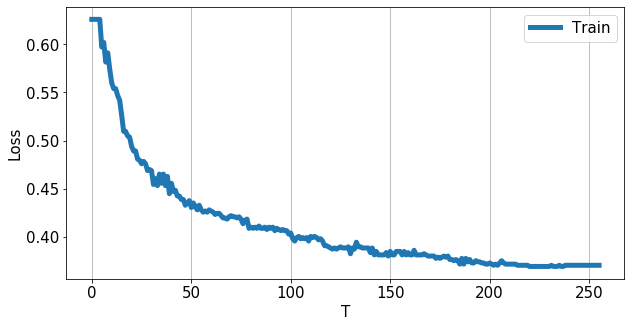

In [113]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

t = 8
axs.plot(np.arange(2**t), np.array(train_losses[0])[:, 1], label=f"Train", linewidth=5)
#axs.plot(np.arange(2**t), np.array(eval_losses[0])[:, 1], label=f"Test", marker="x")

axs.set_ylabel("Loss", fontsize=15)
axs.set_xlabel("T", fontsize=15)
axs.tick_params(axis='both', which='major', labelsize=15)
axs.grid(axis="x")
axs.legend(fontsize=15)

plt.show()


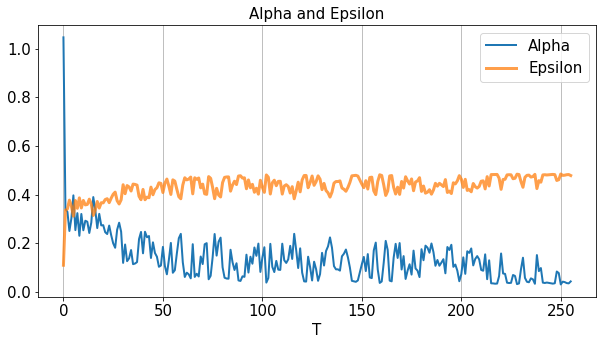

In [114]:

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
t = 8
axs.plot(np.arange(2**t), np.array(alpha_ts[0])[:, 1], label=f"Alpha", linewidth=2)
axs.plot(np.arange(2**t), np.array(epsilon_ts[0])[:, 1], label=f"Epsilon", linewidth=3, alpha=0.75)

axs.set_xlabel("T", fontsize=15)
axs.set_title("Alpha and Epsilon", fontsize=15)
axs.tick_params(axis='both', which='major', labelsize=15)
axs.grid(axis="x")
axs.legend(fontsize=15)

plt.show()


In [79]:
train_pred_aggs[0][0]

(0,
 array([[ 1.04636251, -1.04636251,  1.04636251, ...,  1.04636251,
          1.04636251, -1.04636251]]))

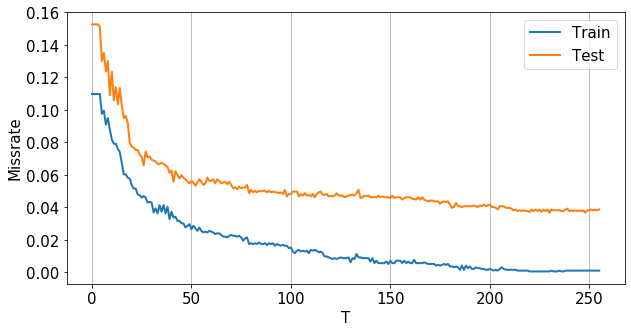

In [115]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
t = 8
train_miss_rate = [miss_rate(ytrain, np.sign(preds)) for i, preds in train_pred_aggs[0]]
eval_miss_rate = [miss_rate(ytest, np.sign(preds)) for i, preds in eval_pred_aggs[0]]
axs.plot(np.arange(2**t), np.array(train_miss_rate), label=f"Train", linewidth=2)
axs.plot(np.arange(2**t), np.array(eval_miss_rate), label=f"Test", linewidth=2)

axs.set_ylabel("Missrate", fontsize=15)
axs.set_xlabel("T", fontsize=15)
axs.tick_params(axis='both', which='major', labelsize=15)
axs.grid(axis="x")
axs.legend(fontsize=15)

plt.show()


In [95]:
#Feature selected to split for each stump
for j in range(len(clfs)):
    p = [i.feature_importances_ for i in clfs[j].stumps]
    q = [np.argmax(i) for i in p]
    print (q)

[211, 237, 235, 190, 235, 462, 241, 158, 158, 429, 238, 347, 326, 427, 403, 266, 234, 240, 492, 712, 209, 484, 313, 467, 328, 191, 490, 213, 373, 236, 742, 233, 709, 709, 220, 742, 130, 745, 266, 375, 469, 434, 211, 494, 463, 191, 718, 471, 742, 206, 127, 744, 464, 461, 191, 742, 244, 181, 212, 156, 746, 341, 341, 742, 742, 404, 624, 745, 745, 481, 742, 327, 428, 745, 745, 185, 572, 709, 238, 261, 737, 737, 652, 652, 484, 666, 244, 464, 739, 665, 665, 464, 471, 739, 634, 746, 210, 341, 546, 632, 737, 317, 652, 652, 439, 313, 266, 266, 463, 153, 212, 463, 380, 380, 264, 206, 469, 314, 465, 388, 652, 742, 742, 634, 742, 153, 544, 745, 719, 719, 402, 214, 208, 239, 296, 462, 220, 666, 191, 746, 376, 427, 260, 185, 350, 350, 742, 742, 271, 266, 266, 481, 350, 182, 745, 745, 604, 518, 350, 737, 737, 207, 237, 434, 739, 739, 267, 348, 469, 265, 544, 716, 313, 313, 221, 739, 213, 153, 341, 341, 491, 634, 207, 494, 342, 264, 246, 745, 413, 666, 632, 271, 232, 212, 289, 372, 244, 244, 742, 742,

In [104]:
print (np.min(np.array(alpha_ts[0])[:, 1]), np.max(np.array(alpha_ts[0])[:, 1]))
print (np.argmin(np.array(alpha_ts[0])[:, 1]), np.argmax(np.array(alpha_ts[0])[:, 1]))


0.030744588326545967 1.046362508696179
250 0


In [105]:
print (np.min(np.array(epsilon_ts[0])[:, 1]), np.max(np.array(epsilon_ts[0])[:, 1]))
print (np.argmin(np.array(epsilon_ts[0])[:, 1]), np.argmax(np.array(epsilon_ts[0])[:, 1]))

0.109805924412666 0.48463254745588336
0 250
